# Yoga Pose Classification Using Tranfer Learning MobileNetV3

Tujuan: Mendeteksi jenis gerakan yoga berdasarkan input gambar dan video

## Import Libraries

In [1]:
# pip install ultralytics

In [2]:
# pip install cvzone

In [5]:
# pip install mlflow

In [130]:
# pip install moviepy

In [19]:
import numpy as np
import pandas as pd
import cv2
import cvzone
import math
import time

import matplotlib.pyplot as plt
from IPython.display import HTML

import pathlib
import matplotlib.image as mpimg
import random
import glob
import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras


## Tentang Dataset

In [20]:
data_dir = pathlib.Path(r'D:\achievment\GDSC\Final\dataset')
class_names = [item.name for item in data_dir.glob('*') if item.is_dir()]
print(class_names)

['adho mukha svanasana', 'adho mukha vriksasana', 'agnistambhasana', 'ananda balasana', 'anantasana', 'anjaneyasana', 'ardha bhekasana', 'ardha chandrasana', 'ardha matsyendrasana', 'ardha pincha mayurasana', 'ardha uttanasana', 'ashtanga namaskara', 'astavakrasana', 'baddha konasana', 'bakasana', 'balasana', 'bhairavasana', 'bharadvajasana i', 'bhekasana', 'bhujangasana', 'bhujapidasana', 'bitilasana', 'camatkarasana', 'chakravakasana', 'chaturanga dandasana', 'dandasana', 'dhanurasana', 'durvasasana', 'dwi pada viparita dandasana', 'eka pada koundinyanasana i', 'eka pada koundinyanasana ii', 'eka pada rajakapotasana', 'eka pada rajakapotasana ii', 'ganda bherundasana', 'garbha pindasana', 'garudasana', 'gomukhasana', 'halasana', 'hanumanasana', 'janu sirsasana', 'kapotasana', 'krounchasana', 'kurmasana', 'lolasana', 'makara adho mukha svanasana', 'makarasana', 'malasana', 'marichyasana i', 'marichyasana iii', 'marjaryasana', 'matsyasana', 'mayurasana', 'natarajasana', 'padangusthasan

In [21]:
print("Number of classes:", len(class_names))

Number of classes: 107


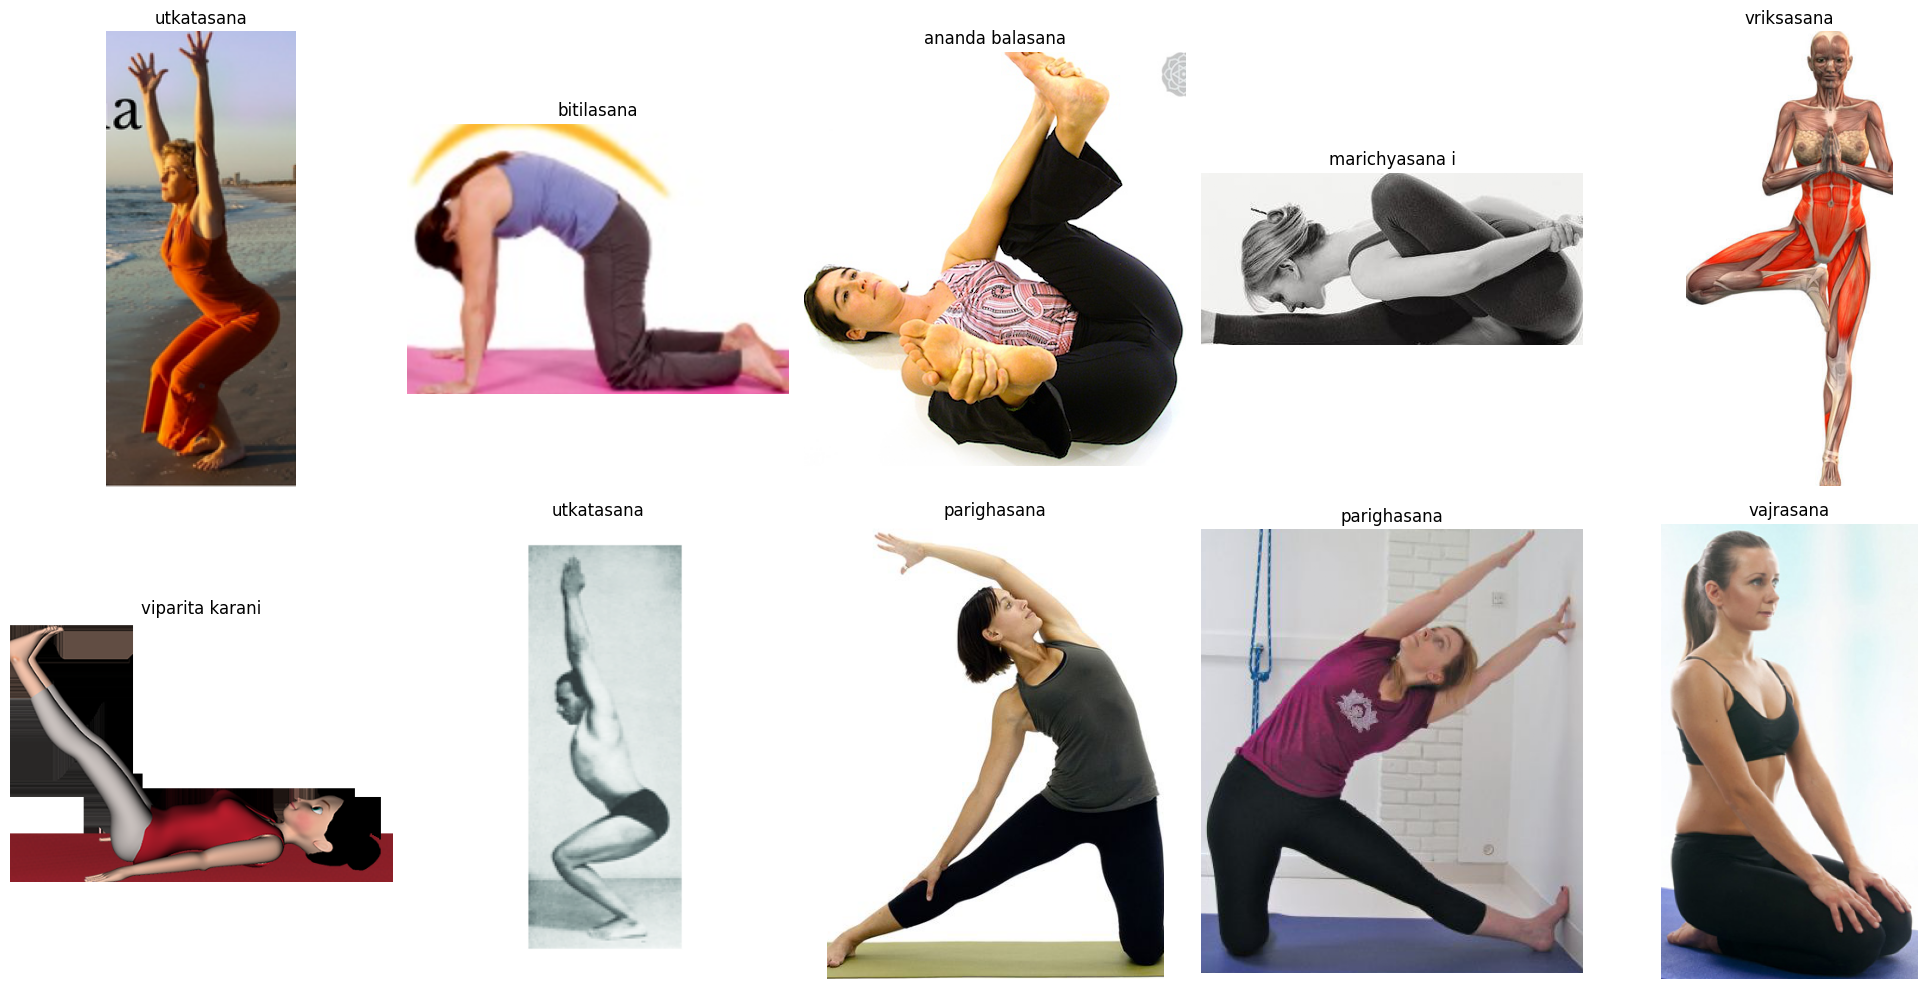

In [22]:
# Initialize a list to store the image paths and their class names
images_and_classes = []

# Loop over each class and add the image paths to the list
for class_name in class_names:
    image_paths = list((data_dir / class_name).glob('*'))
    for img_path in image_paths:
        images_and_classes.append((img_path, class_name))

# Select 25 random images
random_images_and_classes = random.sample(images_and_classes, 10)

# Create a figure
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# Loop through each subplot and display a random image
for ax, (img_path, class_name) in zip(axes.flatten(), random_images_and_classes):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

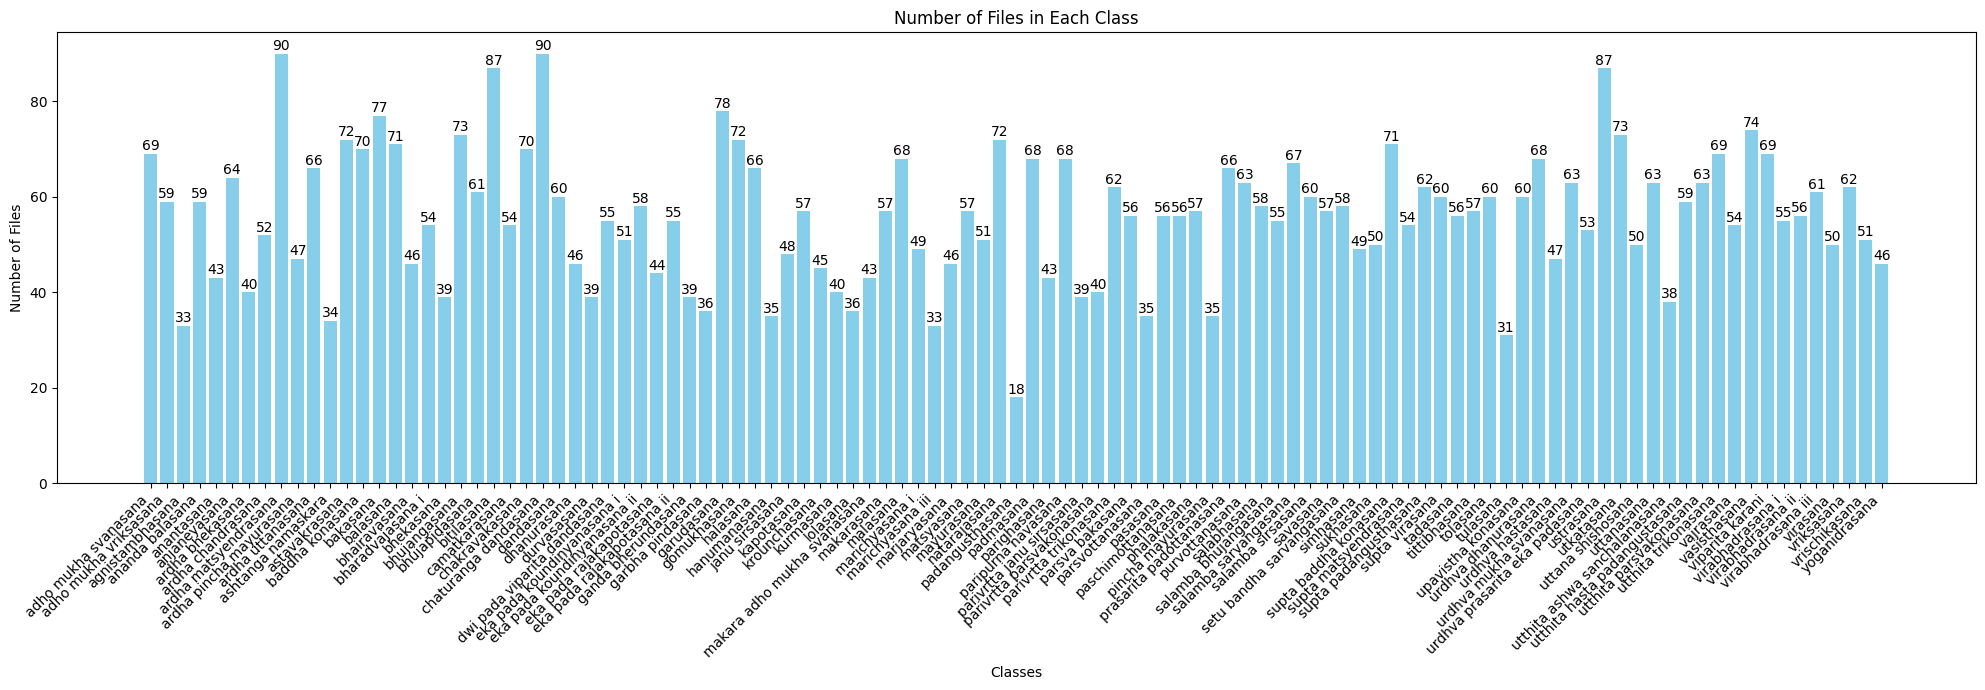

Total number of files across all folders: 5994


In [23]:
# Create a dictionary to store folder names and file counts
folder_file_counts = {}

# Iterate over each folder in the data directory
for folder in data_dir.glob('*'):
    if folder.is_dir():
        # Count the number of files in the folder
        file_count = len(list(folder.glob('*')))
        folder_file_counts[folder.name] = file_count

# Prepare data for plotting
folders = list(folder_file_counts.keys())
file_counts = list(folder_file_counts.values())

# Plotting
plt.figure(figsize=(20, 7))
bars = plt.bar(folders, file_counts, color='skyblue')

# Adding value labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1,  # +0.1 to add a bit of space above the bar
             int(yval), ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Classes')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


# Calculate and print the total number of files across all folders
total_files = sum(folder_file_counts.values())
print("Total number of files across all folders:", total_files)


In [24]:
print("Number of classes:", len(class_names))

Number of classes: 107


Dapat dilihat bahwasannya, dataset terdiri dari `107 classes` jenis gerakan Yoga Asana. Persebaran masing-masing kelas dapat dilihat melalui grafik diatas dengan total file sebanyak `5.994 Files` dalam `format .png`

## Build Model

In [25]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential

### Spliting Data

In [63]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 107


input_directory = "dataset"
train_dataset = image_dataset_from_directory(input_directory,
                                             shuffle=True,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(input_directory,
                                             shuffle=True,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 5993 files belonging to 107 classes.
Using 4795 files for training.
Found 5993 files belonging to 107 classes.
Using 1198 files for validation.


In [27]:
class_names = train_dataset.class_names
print(class_names)

['adho mukha svanasana', 'adho mukha vriksasana', 'agnistambhasana', 'ananda balasana', 'anantasana', 'anjaneyasana', 'ardha bhekasana', 'ardha chandrasana', 'ardha matsyendrasana', 'ardha pincha mayurasana', 'ardha uttanasana', 'ashtanga namaskara', 'astavakrasana', 'baddha konasana', 'bakasana', 'balasana', 'bhairavasana', 'bharadvajasana i', 'bhekasana', 'bhujangasana', 'bhujapidasana', 'bitilasana', 'camatkarasana', 'chakravakasana', 'chaturanga dandasana', 'dandasana', 'dhanurasana', 'durvasasana', 'dwi pada viparita dandasana', 'eka pada koundinyanasana i', 'eka pada koundinyanasana ii', 'eka pada rajakapotasana', 'eka pada rajakapotasana ii', 'ganda bherundasana', 'garbha pindasana', 'garudasana', 'gomukhasana', 'halasana', 'hanumanasana', 'janu sirsasana', 'kapotasana', 'krounchasana', 'kurmasana', 'lolasana', 'makara adho mukha svanasana', 'makarasana', 'malasana', 'marichyasana i', 'marichyasana iii', 'marjaryasana', 'matsyasana', 'mayurasana', 'natarajasana', 'padangusthasan

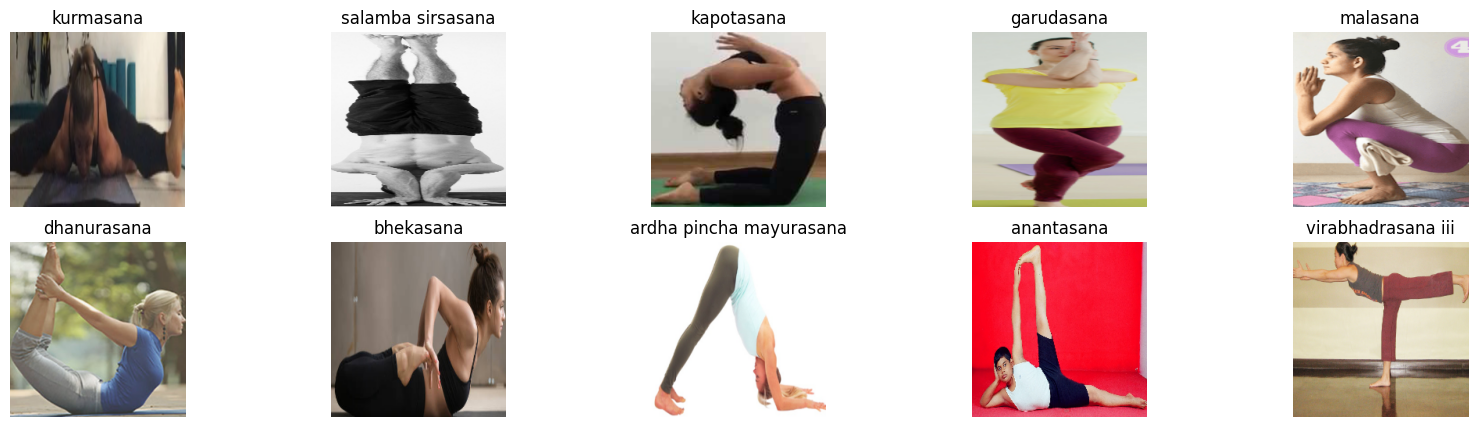

In [30]:
plt.figure(figsize=(20, 5))
for images, labels in train_dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
def build_model():
    mobilenet = tf.keras.applications.MobileNetV3Small(
        weights='imagenet',
        include_top=False,
        input_shape=(224,224,3),
    )
    model = Sequential()
    
    model.add(mobilenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(107, activation='softmax'))
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    
    return model

In [33]:
import mlflow
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))

def get_experiment_id(name):
    exp = mlflow.get_experiment_by_name(name)
    if exp is None:
      exp_id = mlflow.create_experiment(name)
      return exp_id
    return exp.experiment_id

exp_id = get_experiment_id("yoga_colab")

In [67]:
# Enable auto-logging to MLflow
mlflow.tensorflow.autolog(disable=True)

# Simplified test run
with mlflow.start_run(experiment_id=exp_id):
    model = build_model()
    
    # Define callbacks
    checkpoint = ModelCheckpoint('./Saved_Models/best_model_2.keras', save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Increase verbosity and add logging
    import logging
    import tensorflow as tf

    tf.get_logger().setLevel('INFO')
    logging.basicConfig(level=logging.DEBUG)
    
    history = model.fit(
        train_dataset,
        epochs=100,  # Fewer epochs for initial testing
        batch_size=32,
        verbose=2,
        callbacks=[checkpoint, early_stopping],
        validation_data=validation_dataset
    );

Epoch 1/100
150/150 - 120s - 801ms/step - accuracy: 0.0140 - loss: 4.8804 - val_accuracy: 0.0267 - val_loss: 4.6513
Epoch 2/100
150/150 - 100s - 667ms/step - accuracy: 0.0392 - loss: 4.4980 - val_accuracy: 0.0451 - val_loss: 4.4692
Epoch 3/100
150/150 - 95s - 634ms/step - accuracy: 0.0895 - loss: 4.1721 - val_accuracy: 0.0993 - val_loss: 4.1632
Epoch 4/100
150/150 - 97s - 645ms/step - accuracy: 0.1723 - loss: 3.6917 - val_accuracy: 0.1836 - val_loss: 3.6855
Epoch 5/100
150/150 - 94s - 630ms/step - accuracy: 0.2653 - loss: 3.1718 - val_accuracy: 0.2713 - val_loss: 3.1512
Epoch 6/100
150/150 - 96s - 640ms/step - accuracy: 0.3374 - loss: 2.7250 - val_accuracy: 0.3523 - val_loss: 2.7240
Epoch 7/100
150/150 - 98s - 651ms/step - accuracy: 0.4144 - loss: 2.3429 - val_accuracy: 0.4199 - val_loss: 2.4708
Epoch 8/100
150/150 - 100s - 665ms/step - accuracy: 0.4672 - loss: 2.0391 - val_accuracy: 0.4716 - val_loss: 2.2845
Epoch 9/100
150/150 - 98s - 654ms/step - accuracy: 0.5345 - loss: 1.7677 - va

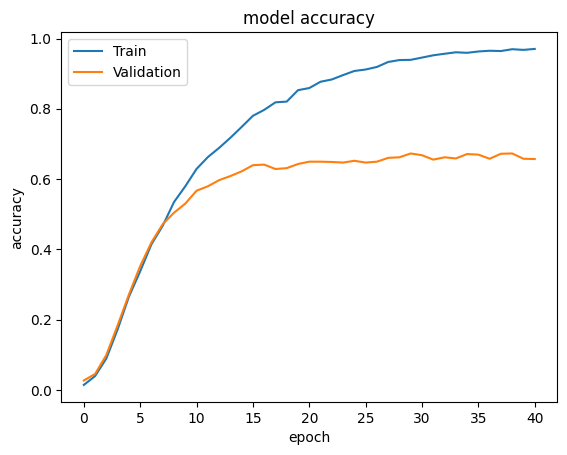

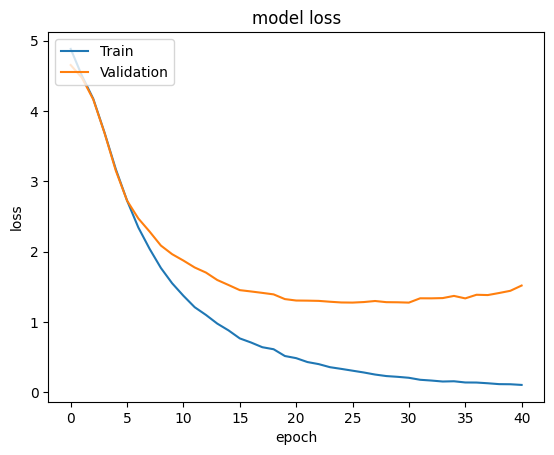

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [69]:
model.evaluate(validation_dataset)

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.6453 - loss: 1.3909


[1.2748680114746094, 0.6677796244621277]

In [70]:
model.save('model_yoga.keras')

In [71]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 107)                 │          61,739 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,978,355 (11.36 MB)

 Trainable params: 988,747 (3.77 MB)

 Non-trainable params: 12,112 (47.31 KB)

 Optimizer params: 1,977,496 (7.54 MB)

In [72]:
for element in train_dataset.take(1):
  # Assuming your dataset contains image and label tensors
  image, label = element
  print(f"Image shape: {image.shape}")
  print(f"Label shape: {label.shape}")

Image shape: (32, 224, 224, 3)
Label shape: (32,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


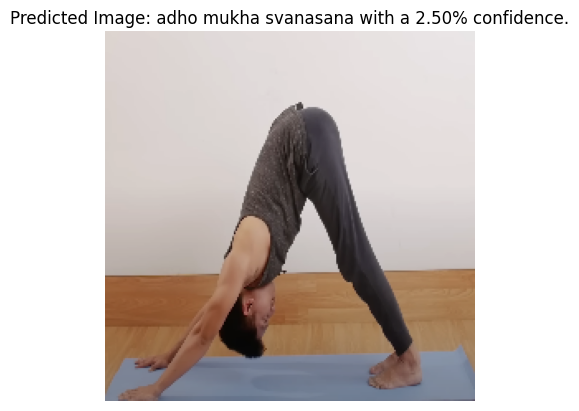

In [80]:
# Define the file path
file_path = r"C:\Users\62877\Pictures\Screenshots\ss_tes.png"

# Check if the file exists and is readable
if os.path.exists(file_path) and os.access(file_path, os.R_OK):
    # Load and preprocess the image
    im2 = cv2.imread(file_path)
    if im2 is not None:
        im2 = cv2.resize(im2, (224, 224))
        img2 = tf.expand_dims(im2, 0)
        
        # Assuming model and class_names are already defined
        predictions = model.predict(img2)
        score = tf.nn.softmax(predictions[0])
        
        # Plotting the image and prediction
        plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.title("Predicted Image: {} with a {:.2f}% confidence."
                  .format(class_names[np.argmax(score)], 100 * np.max(score)))
        plt.axis("off")
        plt.show()
    else:
        print("Failed to read the image file.")
else:
    print("File does not exist or is not readable.")

In [89]:
def download_youtube_videos(youtube_video_url, output_directory):
     '''
    This function downloads the youtube video whose URL is passed to it as an argument.
    Args:
        youtube_video_url: URL of the video that is required to be downloaded.
        output_directory:  The directory path to which the video needs to be stored after downloading.
    Returns:
        title: The title of the downloaded youtube video.
    '''
 
     # Create a video object which contains useful information about the video.
     video = pafy.new(youtube_video_url)
 
     # Retrieve the title of the video.
     title = video.title
 
     # Get the best available quality object for the video.
     video_best = video.getbest()
 
     # Construct the output file path.
     output_file_path = f'{output_directory}/{title}.mp4'
 
     # Download the youtube video at the best available quality and store it to the contructed path.
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title

In [91]:
import pafy

In [125]:
import os
import re

def download_youtube_videos(video_id, directory):
    # Dummy implementation, replace with actual download logic
    # For example, you could use pytube library here
    print(f"Downloading video with ID: {video_id} to {directory}")
    # Assuming the video title is the video ID for this dummy implementation
    return video_id

# Ensure the output directory exists
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)

# Define the YouTube Shorts URL
youtube_shorts_url = 'https://youtu.be/6InUR2GpbBs?si=NVWJZvUkGPacMgis'

# Extract the video ID from the URL
video_id_match = re.search(r'(?:https://www.youtube.com/shorts/|https://youtu.be/)([\w-]{11})', youtube_shorts_url)
if video_id_match:
    video_id = video_id_match.group(1)
else:
    raise ValueError(f"Invalid YouTube Shorts URL: {youtube_shorts_url}")

# Download the YouTube video
video_title = download_youtube_videos(video_id, test_videos_directory)

# Get the path to the downloaded video
input_video_file_path = os.path.join(test_videos_directory, f'{video_title}.mp4')

print(f"Video downloaded to: {input_video_file_path}")

Video downloaded to: test_videos\6InUR2GpbBs.mp4


In [126]:
import cv2
import numpy as np

def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    IMAGE_HEIGHT = 224
    IMAGE_WIDTH = 224

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255.0
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Convert the frames list to a numpy array
    frames_array = np.array(frames_list)

    # Predict for each frame individually and aggregate results
    predicted_labels_probabilities = []
    for frame in frames_array:
        frame_expanded = np.expand_dims(frame, axis=0)
        probabilities = model.predict(frame_expanded)[0]
        predicted_labels_probabilities.append(probabilities)

    # Aggregate the predictions (e.g., using the average)
    predicted_labels_probabilities = np.mean(predicted_labels_probabilities, axis=0)
    
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = class_names[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object.
    video_reader.release()

In [127]:
SEQUENCE_LENGHT=20

In [128]:
from moviepy.editor import *

In [132]:
# Construct tihe nput youtube video path
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, 20)

# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Action Predicted: utkatasana
Confidence: 0.42106205224990845
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
